In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import joblib
import seaborn as sns
import nltk
from collections import Counter


#Loading the data
x_train=pd.read_csv('../data/processed/x_train.csv',delimiter=',')
y_train=pd.read_csv('../data/processed/y_train.csv',delimiter=',')

#Splitting the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=42)

print(x_train.head())
print(y_train.head())

                                                   title  \
36335  badass israeli stabbed by palestinian…pulls kn...   
12384  rhetoric aside, latin america leaders say trum...   
24419  leaked documents show how this american citize...   
24740   trump was whining about white house leaks. ch...   
27039  rachel maddow announces plan to reveal trump’s...   

                                                    text          subject  \
36335  wow   guy deserv  medal  honor   act   strengt...        left-news   
12384  new york  reuter    presid donald trump attack...        worldnews   
24419  leak document  georg soro open societi foundat...  government news   
24740    mind baffl  donald trump still   learn   mak...             news   
27039                    maddow   freak     second mark          politics   

             date  
36335  2016-03-10  
12384  2017-09-22  
24419  2017-04-06  
24740  2017-02-14  
27039  2017-03-14  
       label
36335      0
12384      1
24419      0
2474

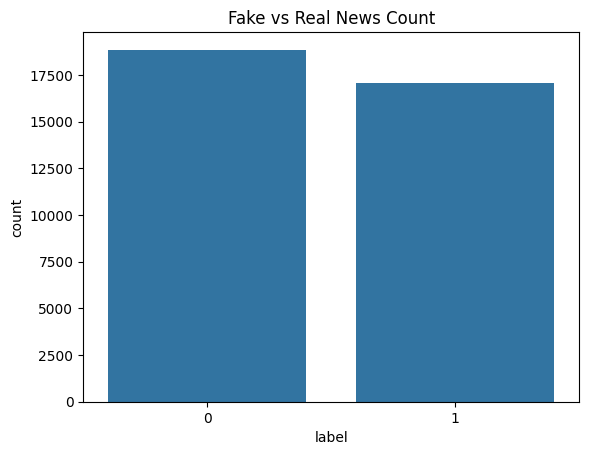

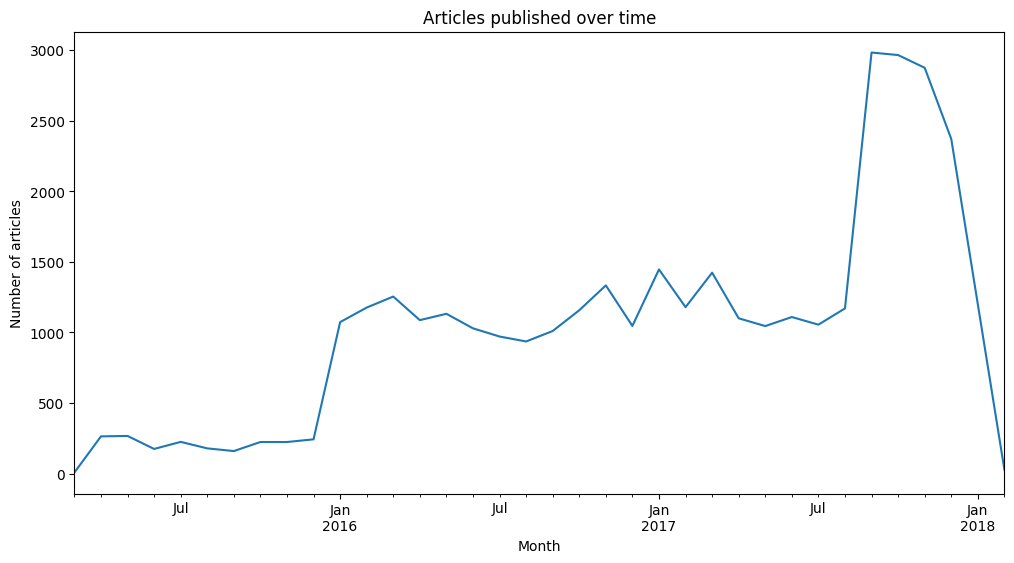

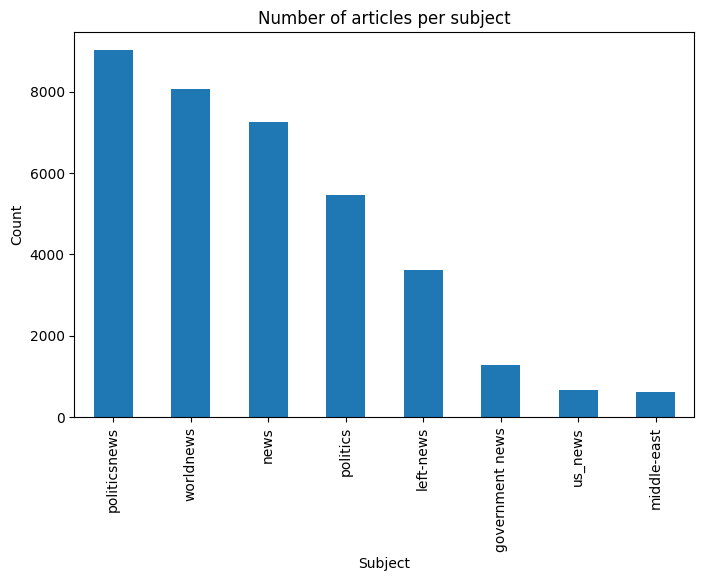

In [7]:
#Visualizing the distribution of labels in the training set
sns.countplot(x='label', data=y_train)
plt.title("Fake vs Real News Count")
plt.show()


#Visualizing the number of articles published over time
x_train['date'] = pd.to_datetime(x_train['date'], errors="coerce")
x_train.groupby(x_train['date'].dt.to_period("M")).size().plot(kind="line", figsize=(12,6))

plt.title("Articles published over time")
plt.xlabel("Month")
plt.ylabel("Number of articles")
plt.show()

#Visualizing the distribution of subjects in the training set
x_train['subject'].value_counts().plot(kind="bar", figsize=(8,5))
plt.title("Number of articles per subject")
plt.xlabel("Subject")
plt.ylabel("Count")
plt.show()
